### Ensemble comparison.

In this notebook we implement the 'joint-criteria' ensemble selection method with HAC.

#### Note: refactor functions so that they can be run with a subset of the data (e.g. 80% of patient for sensitivity analysis). Also test with and without parametric-UMAP.


###### Note: currently liking solution with no filtering and these params (and NMI_SCORE='mi' makes no difference):
```SEARCH_TYPE = 'randomized_search'  # we want random parameterisations for diversity.
SAMPLE_SIZE = 200  # number of sample to take from each pipeline to build library 
RUN_IDS_TO_INCLUDE = [1, 2, 5, 6]  # we will reproduce using only kmeans (and including p-umap)
NMI_SCORE = 'norm'  # arg to pass to clustering_similarity method to use partial NMI (ignoring -1 labels from hdbscan) 
SEED = 42```
Gives 5 sensibly sized clusters at t=0.047 (with library t=15.5).

In [1]:
import matplotlib.pyplot as plt
import pickle as pk
import pandas as pd
import numpy as np
import wandb
from itertools import combinations
import networkx as nx
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

from utilities import run_configs, load_symptom_data, modularity, clustering_similarity

%matplotlib inline

In [2]:
SEARCH_TYPE = 'randomized_search'  # we want random parameterisations for diversity.
SAMPLE_SIZE = 200  # number of sample to take from each pipeline to build library 
RUN_IDS_TO_INCLUDE = [1, 2, 5, 6]  # we will reproduce using only kmeans (and including p-umap)
NMI_SCORE = 'mi'  # arg to pass to clustering_similarity method to use partial NMI (ignoring -1 labels from hdbscan) 
SEED = 42

In [3]:
np.random.seed(SEED)

In [4]:
run_metadata = {
    'randomized_search': {
        1: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/ndz8b3cz',
            'results_path': 'results/umap_kmeans_silhouette_run_10/all_results.pickle'
        },
        2: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/gcnqmv1k',
            'results_path': 'results/umap_kmeans_dbcv_run_11/all_results.pickle'
        },
        3: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/t0tzp4gz',
            'results_path': 'results/umap_hdbscan_silhouette_run_10/all_results.pickle'
        },
        4: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/zgsa9yi4',
            'results_path': 'results/umap_hdbscan_dbcv_run_11/all_results.pickle'
        },
        5: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/x42hq5ez',
            'results_path': 'results/pca_kmeans_silhouette_run_10/all_results.pickle'
        },
        6: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/qgy8ifuf',
            'results_path': 'results/pca_kmeans_dbcv_run_10/all_results.pickle'
        },
        7: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/en968oqc',
            'results_path': 'results/pca_hdbscan_silhouette_run_10/all_results.pickle'
        },
        8: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/ocncbqca',
            'results_path': 'results/pca_hdbscan_dbcv_run_10/all_results.pickle'
        },
        13: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/lo5r07or',
            'results_path': 'results/parametric_umap_kmeans_silhouette_run_10/all_results.pickle'
        },
        15: {
            'run_path': 'rusty-chris/tune_shallow_clustering/tv9hnbnn',
            'results_path': 'results/parametric_umap_hdbscan_silhouette_run_10/all_results.pickle'
        }
    }
}

#### First we assemble our library of clusterings by selecting from the prior optimisation runs.

In [5]:
for key in run_metadata[SEARCH_TYPE].keys():
    run_configs[key].update(run_metadata[SEARCH_TYPE][key])

In [6]:
def load_results(run_id):
    run_config = run_configs[run_id]
    with open(run_config['results_path'], 'rb') as outfile:
        results = pk.load(outfile)
        
    results = pd.DataFrame.from_dict(results, orient='index')
    results['original_index'] = results.index
    results['run_id'] = run_id
    return results

In [7]:
def filter_results(_results, min_size=2, noise_threshold=0.66):
    _results = _results[_results.cluster_count > min_size]
#     _results = _results[_results.fraction_clustered > noise_threshold]
    
    return _results

In [8]:
def sample_results(_results):
    if len(_results) < SAMPLE_SIZE:
        return _results
    else:
        return _results.sample(SAMPLE_SIZE)

In [9]:
all_results = {
#     run_id: sample_results(filter_results(load_results(run_id)))
    run_id: sample_results(load_results(run_id))
    for run_id in run_metadata[SEARCH_TYPE].keys()
}

In [10]:
library = all_results[RUN_IDS_TO_INCLUDE[0]]
for run_id in RUN_IDS_TO_INCLUDE[1:]:
    library = pd.concat(
        [library, all_results[run_id]], ignore_index=True
    )

#### We then produce a final partition from the full library, which will be used to compute diversity and quality metrics...

In [11]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [12]:
df = pd.DataFrame(library.labels)
df = pd.DataFrame(df['labels'].to_list()).transpose()

In [13]:
co_association_matrix = np.zeros([6031, 6031])
n_estimators = len(library)

for ri, row in df.iterrows():
    
    if ri % 500 == 0:
        print(ri)
        
    compare = df.loc[ri + 1:]
    shared_counts = ((row == compare) * (row != -1) * (compare != -1)).sum(axis=1)
    co_association_matrix[ri,ri+1:] = shared_counts / n_estimators

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [14]:
distance_matrix = 1 - co_association_matrix

In [15]:
linkage_matrix = hierarchy.linkage(distance_matrix, method='average')

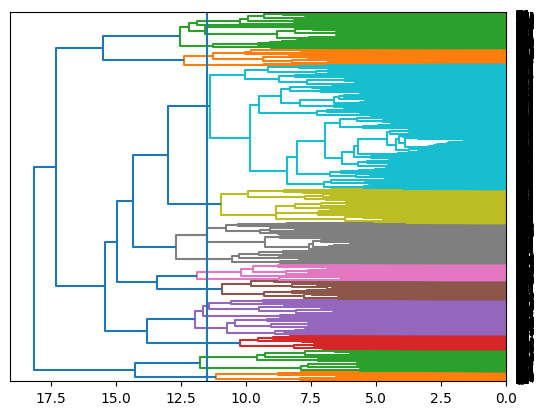

In [16]:
plt.figure()
ax = plt.gca()
dendro_row = hierarchy.dendrogram(linkage_matrix, orientation='left', ax=ax)
ax.axvline(11.5)

In [17]:
clusters = hierarchy.fcluster(linkage_matrix, t=15.5, criterion='distance')

In [18]:
np.unique(clusters, return_counts=True)

(array([1, 2, 3], dtype=int32), array([ 519, 4647,  865]))

#### We now define the Quality and Diversity metrics that will be used for ensemble selection:

In [19]:
def quality(ensemble, library_clustering, score=clustering_similarity):
    """
    Mean of normalized mutual information.
    
    Note: Fern and Lin define 'sum' not 'mean' but this must be wrong?
    """
    return np.mean([
        score(library_clustering, c, score=NMI_SCORE)
        for c in ensemble
    ])

In [20]:
quality(library.iloc[0:100].labels, clusters)

0.22672469194943115

In [21]:
def diversity(ensemble, score=clustering_similarity ):
    pairs = list(combinations(ensemble, 2))
    
    return 1 - np.mean([
        score(pair[0], pair[1], score=NMI_SCORE)
        for pair in pairs
    ])

In [22]:
diversity(library.iloc[0:20].labels)

0.41697787548258114

#### And the multi-objective criterion that combines them:

In [23]:
def criterion(ensemble, library_clustering, alpha=0.5):
    return (
        alpha * quality(ensemble, library_clustering)
        + (1 - alpha) * diversity(ensemble)
    )

In [24]:
criterion(library.iloc[0:100].labels, clusters)

0.33210303809281483

#### And we now the greedy routine that will optimise the criterion to select the ensemble:

In [25]:
def build_ensemble(library, library_clustering):
    
    ensemble_indices = []
    ensemble = []
    
    # first we select the highest quality clustering
    all_quality = [
        quality([c], library_clustering)
        for c in library
    ]
    best_index = np.argmax(all_quality)
    
    ensemble_indices.append(best_index)
    ensemble.append(library[best_index])
    
    # now we greedily add the clustering that maximises the criterion
    old_best = 0
    while True:
        
        new_scores = [
            criterion(ensemble + [c], library_clustering)
            if i not in ensemble_indices
            else -1
            for i,c in enumerate(library)
        ]
        best_index = np.argmax(new_scores)
        new_best = new_scores[best_index]
        if new_best < old_best:
            break
        else:
            old_best = new_best
            ensemble_indices.append(best_index)
            ensemble.append(library[best_index])
    
    print(old_best)
    return ensemble, ensemble_indices

In [26]:
ensemble, e_indices = build_ensemble(library.labels, clusters)

0.48317838351872444


In [27]:
criterion(ensemble, clusters)

0.48317838351872444

In [28]:
len(ensemble)

2

#### We now have an ensemble of only 2 clusterings!! Hmm...

#### We proceed to try extracting the final set of clusters:

In [29]:
e_indices

[158, 248]

In [31]:
# assert (library.iloc[9].labels == ensemble[0]).all()
# assert (library.iloc[192].labels == ensemble[1]).all()

In [32]:
np.unique(library.iloc[158].labels, return_counts=True)

(array([0, 1, 2], dtype=int32), array([2505, 1002, 2524]))

In [33]:
np.unique(library.iloc[248].labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18], dtype=int32),
 array([381, 335, 356, 348, 372, 361, 388, 277, 366, 370, 321, 251, 249,
        253, 309, 194, 336, 234, 330]))

### Final partition:

In [34]:
dff = pd.DataFrame(ensemble).transpose()

In [35]:
fco_association_matrix = np.zeros([6031, 6031])
n_estimators = len(ensemble)

for ri, row in df.iterrows():
    
    if ri % 500 == 0:
        print(ri)
        
    compare = df.loc[ri + 1:]
    shared_counts = ((row == compare) * (row != -1) * (compare != -1)).sum(axis=1)
    fco_association_matrix[ri,ri+1:] = shared_counts / n_estimators

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [38]:
f_distance_matrix = 1 - fco_association_matrix

In [39]:
f_linkage_matrix = hierarchy.linkage(f_distance_matrix, method='average')

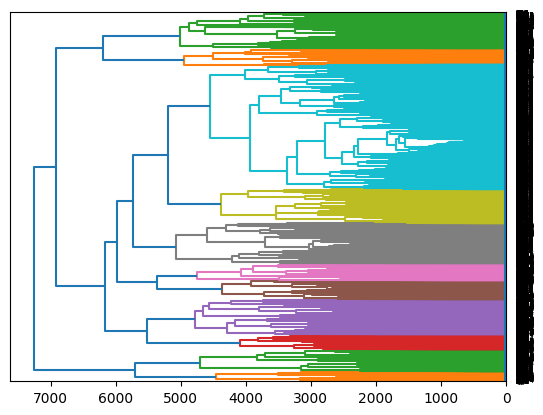

In [40]:
plt.figure()
ax = plt.gca()
dendro_row = hierarchy.dendrogram(f_linkage_matrix, orientation='left', ax=ax)
ax.axvline(11.5)

In [45]:
final_clusters = hierarchy.fcluster(f_linkage_matrix, t=5000, criterion='distance')

In [46]:
np.unique(final_clusters, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32),
 array([ 162,  357,  245,  577,  305,  283,  214,  437,  559, 2027,  271,
         132,  462]))

In [47]:
tessa = pd.read_csv('../clusterings/tessa/cluster_13_111023.csv')
tessa.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

In [50]:
adjusted_mutual_info_score(tessa.cluster, final_clusters)

0.31556940631789265